## Test with real image data and multiple filters

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage import feature
from sklearn.ensemble import RandomForestClassifier
import os
import imageio

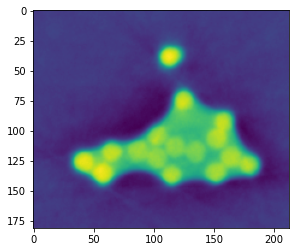

In [2]:
im = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\test_im.tif")
plt.imshow(im)
# "U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\water_truth.tif"

### load label images iteratively optimized in trainable weka segmentation

In [3]:
air = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\air_truth.tif")>0
water = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\water_truth.tif")>0
fiber = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\fiber_truth.tif")>0
truth = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\test_truth.tif")

### develop feature Stack creation as in trainable weka segmentaion (TWS)
#### TWS creates Gaussian Blurs for sigma=0,1,2,4,8,16,... (whatever the limit is)
#### on each sigma, a sobel and hessian filter is applied
#### for hessian one image each for hessian, hessian trace, hessian determinant, hessian eigenvalue 1 & 2, hessian orientation, hessian square eigenvalue difference, normalized eigenvalue difference
#### difference of gaussians for all: larger sigma - smaller


#### Filters in TWS

In [4]:
def TWS_gaussian(im, sig=0):
    G = filters.gaussian(im, sigma=sig, mode='reflect')
    fullname = ''.join(['gaussian_',f'{sig:.1f}'])
    return G, fullname

def TWS_gaussian_stack(im, sigmas):
    fullnames = []
    gstack = np.zeros((im.shape[0],im.shape[1], len(sigmas)))
    for sig,i in zip(sigmas, range(len(sigmas))):
        gstack[:,:,i], name = TWS_gaussian(im, sig)
        fullnames.append(name)
    return gstack, fullnames

def TWS_sobel(im, sig):
    #sigma is only passed to the name! make sure it's correct
    S = filters.sobel(im, mode='reflect')
    name = ''.join(['sobel_',f'{sig:.1f}'])
    return S, name

def TWS_sobel_stack(gstack, sigmas):
    Sstack = np.zeros(gstack.shape)
    fullnames = []
    for i in range(len(sigmas)):
        Sstack[:,:,i], name = TWS_sobel(gstack[:,:,i], sigmas[i])
        fullnames.append(name)
    return Sstack, fullnames

def TWS_hessian(im, sig):
    #creates 8 images per sigma
    #sigma is only passed to the name! make sure it's correct
    Hxx, Hxy, Hyy =  feature.hessian_matrix(im)
    a, b, d =  feature.hessian_matrix(im, mode='reflect')
    c = b
    
    mod = np.sqrt(a**2+b*c+d**2)
    trace = a+d
    det = a*d-c*b
    eig1 = (a+d)/2 + np.sqrt((4*b**2+(a-d)**2)/2)
    eig2 = (a+d)/2 - np.sqrt((4*b**2+(a-d)**2)/2)
    orient = 0.5*np.arccos(4*b**2+(a-d)**2)
    gamma_norm_eig_diff = (a-d)**2*((a-d)**2+4*b**2)
    square_norm_eig_diff = ((a-d)**2+4*b**2) 
    
    hessian_stack = np.dstack([mod,trace,det,eig1,eig2,orient,gamma_norm_eig_diff,square_norm_eig_diff])
    names = ['module', 'trace', 'determinant', 'eigenvalue1', 'eigenvalue2', 'orientation', 'gamma_norm_eig_diff', 'square_norm_eig_diff']
    fullnames = []
    for name in names:
        fullname = ''.join(['hessian_',name,'_',f'{sig:.1f}'])
        fullnames.append(fullname)
    return hessian_stack, fullnames

def TWS_hessian_stack(gstack, sigmas):
    size = len(sigmas)*8
    Hstack = np.zeros((gstack.shape[0],gstack.shape[1], size))
    fullnames = []
    for i in range(len(sigmas)):
        Hstack[:,:,i*8:i*8+8], names = TWS_hessian(gstack[:,:,i],sigmas[i])
        fullnames = fullnames + names
    return Hstack, fullnames
        

def TWS_diff_of_gaussians(gstack, sigmas):
    #creates a stack of {size} (see below)
    n = len(sigmas)
    size = int(n*(n-1)/2)
    
    diff_stack = np.zeros((im.shape[0], im.shape[1], size))
    fullnames = []
    cc = 0
    for i in range(1,n):
        for j in range(i):
            DG = gstack[:,:,i]-gstack[:,:,j]
            diff_stack[:,:,cc] = DG
            name = ''.join(['diff_of_gauss_',f'{sigmas[i]:.1f}','_',f'{sigmas[j]:.1f}'])
            fullnames.append(name)
            cc = cc + 1
    return diff_stack, fullnames
            
            
    
    

#### reverse engineered feature stack

In [6]:
def TWS_feature_stack(im, sigmas):
    #TODO: allow ticking off features
        #gaussian filters
        g_stack, gfeat = TWS_gaussian_stack(im, sigmas)
        #sobel filter on every gaussian sigma
        s_stack, sfeat = TWS_sobel_stack(g_stack, sigmas)
        #stack of hessian stacks for every sigma
        h_stack, hfeat = TWS_hessian_stack(g_stack, sigmas)
        #diff of gaussians
        d_stack, dfeat = TWS_diff_of_gaussians(g_stack, sigmas)
        
        feat_stack = np.dstack([g_stack, s_stack, h_stack, d_stack])
        # feat_stack = np.dstack([g_stack, d_stack])
        feat_names = gfeat+sfeat+hfeat+dfeat
        # feat_names = gfeat+dfeat
        
        return feat_stack, feat_names
        
        
        
    

### Function to classify one slice automatically detecting phases in truth image

In [29]:
def label_data_slice(im, truth, sigmas, feat_stack=None):
    #TODO: automatically detect phases in truth image and aovid overlap
    #TODO: define format of truth image
    phase1 = truth==1
    phase2 = truth==2
    phase3 = truth==4
    
    if feat_stack is None:
        feat_stack, _ = TWS_feature_stack(im, sigmas)
    
    X1 = feat_stack[phase1]
    y1 = np.zeros(X1.shape[0])
    X2 = feat_stack[phase2]
    y2 = np.ones(X2.shape[0])
    X3 = feat_stack[phase3]
    y3 = 2*np.ones(X3.shape[0])

    y = np.concatenate([y1,y2,y3])
    X = np.concatenate([X1,X2,X3])
    
    return X,y, feat_stack


In [25]:
 def classify_and_plot(X,y,im, feat_stack, plot=True):
    # TODO: allow choice and manipulation of ML method
    # TODO: carry classifier to final result to make available
    clf =  RandomForestClassifier(n_estimators = 300, n_jobs=-1) 
    clf.fit(X, y)
    num_feat = feat_stack.shape[2]
    ypred = clf.predict(feat_stack.reshape(-1,num_feat))
    result = ypred.reshape(im.shape).astype(np.uint8)
    if plot:
        fig, (ax1, ax2)= plt.subplots(1,2,figsize=(12,7))
        ax1.imshow(im, cmap='Greys_r')
        ax2.imshow(result)
    return result, clf

In [26]:
def slicewise_classify_for_training(im, slice_name, training_path, XTM_data_path, plot=True, sigmas=sigmas, feat_stack=None, truth=None, training_dict=None):
    #consider training data from other slices but do not simpliy append to avoid duplicates
    if training_dict is not None:
        slices = list(training_dict.keys())
        if slice_name in slices: 
            slices.remove(slice_name)
        if len(slices)>0:
            Xall = training_dict[slices[0]][0]
            yall = training_dict[slices[0]][1]
            for i in range(1,len(slices)):
                Xall = np.concatenate([Xall, training_dict[slices[i]][0]])
                yall = np.concatenate([yall, training_dict[slices[i]][1]])
    
    
    if feat_stack is None:
        print('creating feature stack')
        X,y, feat_stack =  label_data_slice(im, truth, sigmas)
    else:
        X,y, feat_stack =  label_data_slice(im, truth, sigmas, feat_stack=feat_stack) 
    
    print('training and classifying')
    
    if training_dict is not None:
        Xt = np.concatenate([Xall,X])
        yt = np.concatenate([yall,y])
        Xall = None
        yall = None
    else:
        Xt = X
        yt = y
    
    result, clf = classify_and_plot(Xt,yt,im, feat_stack, plot)
    
    print('save slice result')
    imageio.imsave(os.path.join(training_path,''.join([slice_name,'_classified.tif'])), result)
    return X, y, feat_stack, clf        

#### end of definitions

### train classifier and plot result on "test" slice

In [5]:
sigmas = [0, 2,4,6,8]  #hard-coded for now, sobel and hessian require that first sigma is 0, diff, gaussian(sig=0) = 0

In [9]:
slice_name = 'test'
training_path = r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat"

In [10]:
im = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\test_im.tif")
air = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\air_truth.tif")>0
water = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\water_truth.tif")>0
fiber = io.imread(r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\fiber_truth.tif")>0
truth = air+water*2+fiber*4

creating feature stack
training and classifying
save slice result


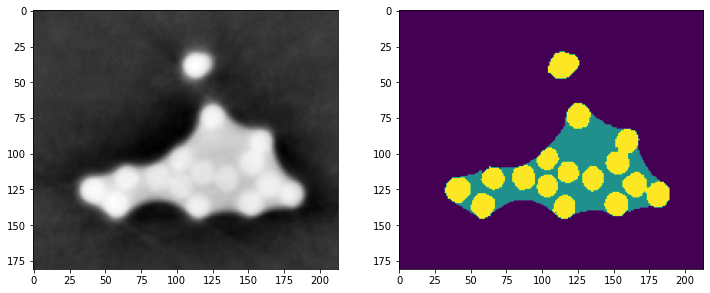

In [12]:
X,y, feat_stack = slicewise_classify_for_training(im, slice_name, truth=truth,training_path = r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat", XTM_data_path = r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat")

In [13]:
training_dict = {}
training_dict[slice_name] = (X,y, feat_stack)

### proper training workflow for 3 phases air, water, fiber TODO: make general

In [14]:
XTM_data_path = r"D:\TOMCAT_2\01_intcorrect_med_leg_0"
training_path = r"U:\01_Python\00_playground\test_pytorch\Dataset\test_tomcat\training"
time_folder = os.listdir(XTM_data_path)
timestep_folder = time_folder[0]
images_first = os.listdir(os.path.join(XTM_data_path, timestep_folder))

In [37]:
# randomly suggest slice for training
num_ts = len(time_folder)
num_slices = len(images_first)

ts = np.random.choice(range(num_ts))+1
print('try time step ',ts )
sn = np.random.choice(range(num_slices))+1
print('try slice number ', sn)

slice_name= ''.join(['ts_',str(ts),'_slice_',str(sn)])
watername = ''.join([slice_name, '_water.tif'])
waterpath = os.path.join(training_path, watername)
if not os.path.exists(waterpath):
    print('create missing training set with ImageJ-script!')

try time step  9
try slice number  326
create missing training set with ImageJ-script!


training and classifying
save slice result


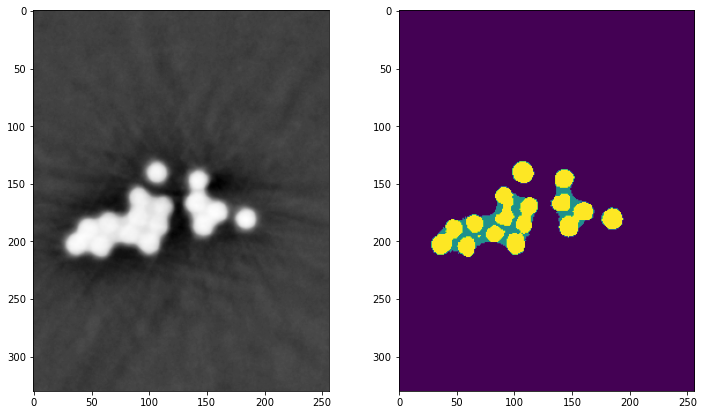

In [27]:
time_step = 15
slice_number = 519

time_folder = os.listdir(XTM_data_path)
timestep_folder = time_folder[time_step]
images = os.listdir(os.path.join(XTM_data_path, timestep_folder))
image_name = images[slice_number]
im = io.imread(os.path.join(XTM_data_path, timestep_folder, image_name))

slice_name= ''.join(['ts_',str(time_step),'_slice_',str(slice_number)])
watername = ''.join([slice_name, '_water.tif'])
waterpath = os.path.join(training_path, watername)
airname = ''.join([slice_name, '_air.tif'])
airpath = os.path.join(training_path, airname)
fibername = ''.join([slice_name, '_fiber.tif'])
fiberpath = os.path.join(training_path, fibername)

air = io.imread(airpath)>0
water = io.imread(waterpath)>0
fiber = io.imread(fiberpath)>0
truth = air+water*2+fiber*4

if slice_name in training_dict.keys():
    X,y, feat_stack, clf = slicewise_classify_for_training(im, slice_name, XTM_data_path=XTM_data_path, training_path=training_path, feat_stack=training_dict[slice_name][2], truth=truth, training_dict=training_dict)
else:
    X,y, feat_stack, clf = slicewise_classify_for_training(im, slice_name, XTM_data_path=XTM_data_path, training_path=training_path, truth=truth, training_dict=training_dict)

training_dict[slice_name] = (X,y, feat_stack)





In [31]:
### make test feature_stack and names
_, feat_names = TWS_feature_stack(im, sigmas)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

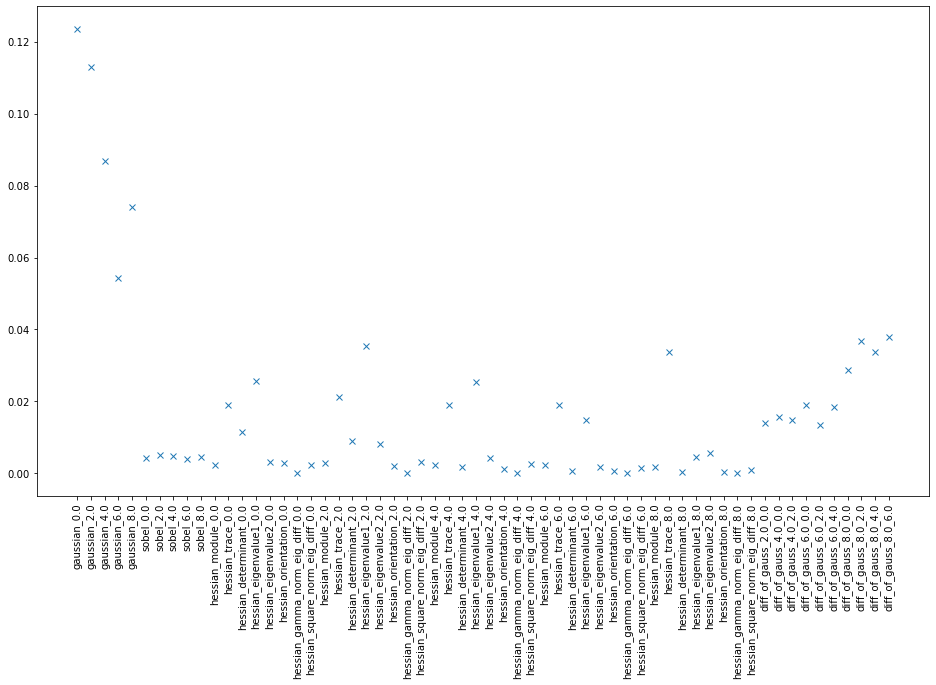

In [32]:
plt.figure( figsize=(16,9))
plt.plot(feat_names,clf.feature_importances_,'x')
plt.xticks(rotation=90)

In [17]:
slice_name

'ts_15_slice_519'

In [18]:
training_dict.keys()

dict_keys(['test', 'ts_15_slice_519'])